- Get network for a bounding box
- Bring in flow data
- Measure centrality
- Derive edge-level attractiveness

In [19]:
import OSM2AT
import pandas as pd
import geopandas as gpd
import graph_tool.all as gt
import numpy as np
import matplotlib.pyplot as plt

In [2]:
area_of_study = gpd.read_file('../local_data/one_DL.geoJSON').to_crs('EPSG:4326')

In [3]:
line_coords = list(area_of_study['geometry'][0].coords)

In [151]:
line_coords

[(0.026062515872869813, 51.45217367655291),
 (-0.11606296821445392, 51.500412545286565)]

In [154]:
line_coords[0][1]

51.45217367655291

In [4]:
bounding_box = tuple([line_coords[1][0],line_coords[0][1],line_coords[0][0],line_coords[1][1]])

In [5]:
G,edges = OSM2AT.get_cycle_network(bounding_box,'mode-rule','ottawa','bb',None)

/home/chris/miniconda3/envs/gt/lib/python3.12/site-packages/OSM2AT/get_at_networks.py:48: FutureWarning: The `north`, `south`, `east`, and `west` parameters are deprecated and will be removed in the v2.0.0 release. Use the `bbox` parameter instead.
  G = ox.graph_from_bbox(bounding_box[3],bounding_box[1], bounding_box[0], bounding_box[2],network_type = 'bike',retain_all=True,simplify=False)
/home/chris/miniconda3/envs/gt/lib/python3.12/site-packages/OSM2AT/get_at_networks.py:55: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  edge_attributes['cent_x'] = edge_attributes['geometry'].centroid.x
/home/chris/miniconda3/envs/gt/lib/python3.12/site-packages/OSM2AT/get_at_networks.py:56: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this

Imputing Max Speed
Imputing data using method - Mode Rule
Data imputed
Imputing Number of Lanes
Imputing data using method - Mode Rule
Data imputed
Imputing Surface
Index(['osmid', 'oneway', 'highway', 'surface', 'lit', 'bicycle', 'segregated',
       'reversed', 'length', 'name', 'maxspeed', 'motor_vehicle', 'lanes',
       'ref', 'cycleway:left', 'cycleway:both', 'sidewalk', 'cycleway:right',
       'cycleway:right:oneway', 'access', 'service', 'cycleway:left:oneway',
       'cycleway', 'junction', 'busway', 'cycleway:lane', 'cycleway:surface',
       'bridge', 'bus', 'width', 'bicycle:conditional', 'tunnel', 'est_width',
       'area', 'footway', 'path', 'construction', 'geometry', 'cent_x',
       'cent_y', 'edge_index'],
      dtype='object')
Imputing data using method - mode rule
Data imputed
Calculating LTS using Ottawa Advocacy Group method


In [6]:
from geopandas import GeoDataFrame
edge_attributes_gdf = GeoDataFrame(edges, crs="EPSG:4326", geometry=edges['geometry'])
edge_attributes_gdf.columns = edge_attributes_gdf.columns.astype(str)
edge_attributes_gdf.to_file("../local_data/example_bbox.json", driver="GeoJSON")

In [7]:
edges_strava = pd.read_csv("../local_data/all_edges_yearly_2019_ride_london/edges_london.csv")
#test = edges.merge(edges_strava[["osm_reference_id", "forward_commute_trip_count"]], left_on = "osmid", right_on = "osm_reference_id", how = "left")

In [9]:
edges['unique_id'] = range(len(edges))

In [10]:
def get_centrality(edges):

    edge_list = []
    for i,e in edges.iterrows():
        edge_list.append(tuple([str(i[0]),str(i[1]),e['length'],e['LTS'],e['unique_id']]))
        
    g = gt.Graph()

    elength = g.new_ep("float")
    elts = g.new_ep("int")
    eid = g.new_ep("int")

    g.add_edge_list(edge_list, hashed = True,eprops=[elength, elts, eid])

    vp, ep = gt.betweenness(g,weight=elength)

    return vp, ep, g, eid

In [11]:
vp, ep, g, eid = get_centrality(edges)

In [12]:
id_centrality = {}

for e in g.edges():
    id_centrality[eid[e]] = ep[e]

In [13]:
edges['centrality'] = edges['unique_id'].map(id_centrality)

In [14]:
id2centrality = {}
ids = list(edges['osmid'])

for id in ids:
    id2centrality[id] = edges[edges['osmid']==id]['centrality'].mode().values[0]

edges_strava['centrality'] = edges_strava['osm_reference_id'].map(id2centrality)

In [15]:
edges_strava_dedup = edges_strava[edges_strava['centrality'].notna()]

In [17]:
def min_max_normalization(column):
    min_val = column.min()
    max_val = column.max()
    
    normalized_column = (column - min_val) / (max_val - min_val)
    
    return normalized_column

In [22]:
# Apply min-max normalization to the 'Value' column
edges_strava_dedup['forward_commute_trip_count_n'] = min_max_normalization(edges_strava_dedup['forward_commute_trip_count'])
edges_strava_dedup['centrality_n'] = min_max_normalization(edges_strava_dedup['centrality'])

/tmp/ipykernel_216077/3600993532.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  edges_strava_dedup['forward_commute_trip_count_n'] = min_max_normalization(edges_strava_dedup['forward_commute_trip_count'])
/tmp/ipykernel_216077/3600993532.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  edges_strava_dedup['centrality_n'] = min_max_normalization(edges_strava_dedup['centrality'])


<function matplotlib.pyplot.show(close=None, block=None)>

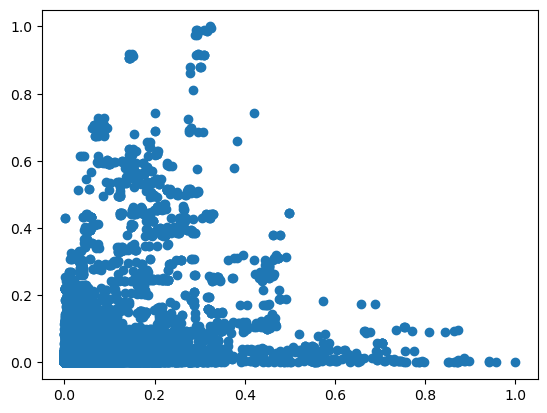

In [23]:
plt.scatter(edges_strava_dedup['forward_commute_trip_count_n'],edges_strava_dedup['centrality_n'])
plt.show

In [24]:
edges_strava_dedup['edge_level_att'] = edges_strava_dedup['forward_commute_trip_count_n'] - edges_strava_dedup['centrality_n']

/tmp/ipykernel_216077/3176965528.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  edges_strava_dedup['edge_level_att'] = edges_strava_dedup['forward_commute_trip_count_n'] - edges_strava_dedup['centrality_n']


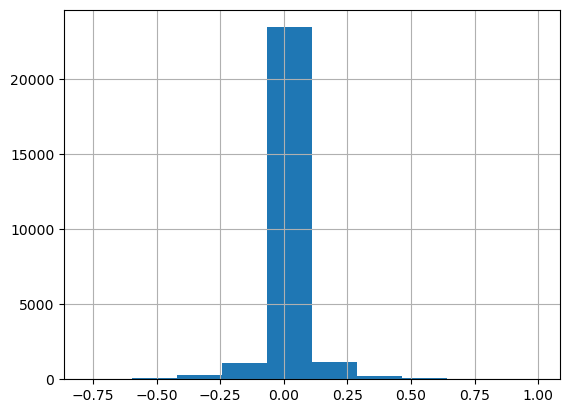

In [25]:
edges_strava_dedup['edge_level_att'].hist()
plt.show()

In [26]:
csna = gpd.read_file('../local_data/CSNA/tracks_joined.geojson')
csna['osm_id'] = csna['osm_id'].astype(int)

In [126]:
csna = csna.dropna(subset=['CSNA_level'])

In [27]:
csna['CSNA_level'].value_counts()

CSNA_level
2.000000    2547
3.000000    1489
0.000000     605
6.000000     421
2.500000     303
            ... 
5.578947       1
5.470588       1
1.947368       1
4.714286       1
1.333333       1
Name: count, Length: 150, dtype: int64

In [28]:
edges_strava_dedup = edges_strava_dedup.merge(csna[['osm_id','CSNA_level']], left_on = 'osm_reference_id', right_on = 'osm_id', how = 'left')

In [29]:
edges_strava_dedup['CSNA_level'].value_counts()

CSNA_level
2.000000    1119
3.000000     944
0.000000     451
2.500000     335
6.000000     212
4.000000      51
5.000000      27
2.056452      19
2.964286       9
2.166667       9
2.305556       8
5.391304       8
3.666667       7
4.363636       7
3.500000       7
2.250000       7
2.300000       6
2.700000       6
2.972222       6
1.947368       6
2.481481       5
2.117647       5
3.931034       5
2.125000       5
4.625000       5
5.548387       5
2.210526       4
5.470588       4
5.636364       4
2.833333       4
3.428571       4
2.157895       3
2.214286       3
2.571429       3
0.454545       3
3.684211       3
2.611111       2
2.200000       2
4.142857       2
3.200000       2
2.800000       2
3.285714       2
2.928571       2
2.950000       2
4.357143       2
2.941176       1
3.250000       1
3.923077       1
4.204545       1
3.333333       1
3.812500       1
1.500000       1
4.285714       1
3.400000       1
5.333333       1
2.590909       1
2.666667       1
4.500000       1
Nam

In [33]:
res = edges_strava_dedup[edges_strava_dedup['CSNA_level'].isin([2,3,4])]

In [41]:
print('Mean edge level att for CSNA 2 : {}'.format(res[res['CSNA_level'] == 2]['edge_level_att'].mean()))
print('Mean edge level att for CSNA 3 : {}'.format(res[res['CSNA_level'] == 3]['edge_level_att'].mean()))
print('Mean edge level att for CSNA 4 : {}'.format(res[res['CSNA_level'] == 4]['edge_level_att'].mean()))

Mean edge level att for CSNA 2 : 0.0009700318849880026
Mean edge level att for CSNA 3 : -0.033972997650777735
Mean edge level att for CSNA 4 : -0.03186149351201414


In [39]:
res[res['CSNA_level'] == 3]['edge_level_att'].mean()

-0.033972997650777735

In [40]:
res[res['CSNA_level'] == 4]['edge_level_att'].mean()

-0.03186149351201414